# T.U.I.A 2024 - Aprendizaje Automático II
## TP 2 - Redes Recurrentes
## Integrantes:
* Ponce, Daniel
* Yañez, Mirian

## Problema 2 - Shakespear

Descripción:

En el siguiente problema, se presenta un conjunto de datos correspondientes a escritos de Shakespear. El objetivo del problema es crear un modelo capaz de generar texto con dialecto de época y escritura en verso y prosa.

Dataset:
https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt


El dataset proporcionado incluye 40000 líneas de distintos escritos de Shakespear. Sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.

Objetivo:

Utilizando el dataset construido, el objetivo es construir modelos de generación de texto utilizando redes neuronales que puedan generar texto con dialecto de época y escritura en verso y prosa. Consultar el siguiente lab como referencia para la implementación:

https://colab.research.google.com/github/FCEIA-AAII/lab10/blob/master/lab10-a.ipynb

Se solicita experimentar con los siguientes tipos de modelos:

Caracter a caracter: entrenar un modelo de generación de texto a nivel de caracteres como el correspondiente al Lab10 mencionado anteriormente.

Palabra a palabra: entrenar un modelo de generación de texto a nivel de palabras, adecuando los procesos de entrenamiento e inferencia según sea necesario.

Generar fragmentos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.

Además se solicita evaluar el impacto de los siguiente factores sobre el texto generado:

Temperatura: Realizar ensayos con valores de temperatura =1, <1, >1.

Longitud de secuencia: Realizar ensayos con distintos valores de longitud de secuencia.

No se requiere un análisis de métricas para este problema, se espera un análisis cualitativo de los resultados obtenidos.

Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

Análisis previo y preprocesamiento del set de datos.

Definición y entrenamiento de los modelos.

Análisis y comparación de los resultados obtenidos para los diferentes modelos.

# Intalamos dependencias

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

# Librerias

In [2]:
import tensorflow as tf
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Definimos la clase 'BaseTextGenerator', que centraliza la lógica compartida para generadores de texto basados en RNN, incluyendo configuración, entrenamiento, y generación de texto.


In [3]:
class BaseTextGenerator(ABC):
    """
    Abstract base class for text generation, providing shared logic
    for character-level and word-level generators.
    """

    def __init__(self, data_dir='.', embedding_dim=256, rnn_units=1024,
                 batch_size=64, seq_length=100):
        """
        Initializes the text generator with shared parameters.

        Args:
            data_dir (str): Directory to store data and checkpoints.
            embedding_dim (int): Dimension of the embedding layer.
            rnn_units (int): Number of units in the RNN layers.
            batch_size (int): Batch size for training.
            seq_length (int): Length of sequences for training.
        """
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(self.__class__.__name__)

        self.data_dir = data_dir
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.vocabulary = None
        self.ids_from_tokens = None
        self.tokens_from_ids = None
        self.training_dataset = None
        self.validation_dataset = None
        self.model = None
        self.corpus = None
        self.token_type = None

        # For tracking loss and perplexity
        self.history = None

        # Configure GPU
        self._configure_gpu()

    def _configure_gpu(self):
        """
        Configures TensorFlow to use the GPU if available.
        """
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                self.logger.info(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
            except RuntimeError as e:
                self.logger.error(f"Error configuring GPU: {e}")

    @abstractmethod
    def load_data(self):
        """
        Abstract method to load and preprocess data.
        """
        pass

    @abstractmethod
    def prepare_dataset(self):
        """
        Abstract method to prepare the dataset for training.
        """
        pass

    def build_model(self):
        """
        Builds the RNN-based text generation model.
        """
        try:
            vocab_size = len(self.ids_from_tokens.get_vocabulary())
            self.model = self.create_model(vocab_size)
            sample_input = tf.zeros([self.batch_size, self.seq_length], dtype=tf.int32)
            self.model(sample_input)
            self.model.summary(print_fn=self.logger.info)
            self.logger.info("Model built successfully.")
        except Exception as e:
            self.logger.error(f"Error building model: {e}")

    @abstractmethod
    def create_model(self, vocab_size):
        """
        Abstract method to create the model. This allows subclasses to define different architectures.
        """
        pass

    def compile_model(self):
        """
        Compiles the model with a suitable optimizer and loss function.
        """
        try:
            loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
            self.model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
            self.logger.info("Model compiled successfully.")
        except Exception as e:
            self.logger.error(f"Error compiling model: {e}")

    def train_model(self, epochs=40):
        """
        Trains the model using the prepared dataset.

        Args:
            epochs (int): Number of epochs to train.
        """
        try:
            checkpoint_dir = os.path.join(self.data_dir, 'training_checkpoints')
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_prefix,
                save_weights_only=True
            )

            # Custom callback to record loss and perplexity
            class PerplexityCallback(tf.keras.callbacks.Callback):
                def __init__(self):
                    super().__init__()
                    self.train_perplexity = []
                    self.val_perplexity = []

                def on_epoch_end(self, epoch, logs=None):
                    train_loss = logs.get('loss')
                    val_loss = logs.get('val_loss')
                    if train_loss is not None:
                        self.train_perplexity.append(np.exp(train_loss))
                    if val_loss is not None:
                        self.val_perplexity.append(np.exp(val_loss))

            self.perplexity_callback = PerplexityCallback()

            self.history = self.model.fit(
                self.training_dataset,
                validation_data=self.validation_dataset,
                epochs=epochs,
                callbacks=[checkpoint_callback, self.perplexity_callback]
            )
            self.logger.info("Model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error training model: {e}")

    def plot_loss_and_perplexity(self):
        """
        Plots the loss and perplexity over epochs.
        """
        if self.history is None:
            self.logger.error("No training history found. Train the model first.")
            return

        epochs = range(1, len(self.history.history['loss']) + 1)

        # Plotting Loss
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history.history['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.history.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting Perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.perplexity_callback.train_perplexity, 'b-', label='Training Perplexity')
        plt.plot(epochs, self.perplexity_callback.val_perplexity, 'r-', label='Validation Perplexity')
        plt.title('Perplexity over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Perplexity')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def generate_text(self, start_string, num_generate=1000, temperature=1.0):
        """
        Generates text using the trained model.

        Args:
            start_string (str): The initial string to start text generation.
            num_generate (int): Number of tokens to generate.
            temperature (float): Temperature parameter for text generation.

        Returns:
            str: The generated text.
        """
        try:
            input_tokens = self.preprocess_start_string(start_string)
            text_generated = []

            # Ensure temperature is positive
            temperature = max(temperature, 1e-5)

            states = None
            for _ in range(num_generate):
                input_ids = self.ids_from_tokens(input_tokens)

                predictions, states = self.model(inputs=input_ids, states=states,
                                                 return_state=True)
                # Get the last prediction
                predictions = predictions[:, -1, :]
                # Adjust for temperature
                predictions /= temperature
                # Sample the next token
                predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()
                # Decode to token
                next_token = self.tokens_from_ids(predicted_id).numpy().decode('utf-8')
                # Prepare the next input
                if self.token_type == 'word':
                    input_tokens = tf.expand_dims([next_token], 0)
                else:
                    input_tokens = tf.expand_dims(list(next_token), 0)
                text_generated.append(next_token)

            if self.token_type == 'word':
                return start_string + ' ' + ' '.join(text_generated)
            else:
                return start_string + ''.join(text_generated)
        except Exception as e:
            self.logger.error(f"Error generating text: {e}")
            return ""

    @abstractmethod
    def preprocess_start_string(self, start_string):
        """
        Preprocesses the start string for text generation.

        Args:
            start_string (str): The initial string.

        Returns:
            tf.Tensor: The processed input tokens.
        """
        pass

## Implementamos la clase 'CharacterLevelTextGenerator', que extiende 'BaseTextGenerator' para generar texto a nivel de caracteres, incluyendo carga de datos, preparación de datasets y creación de modelos optimizados.


In [4]:
class CharacterLevelTextGenerator(BaseTextGenerator):
    """
    A character-level text generator that extends the BaseTextGenerator class.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.token_type = 'char'

    def load_data(self):
        """
        Loads and preprocesses data for character-level training.
        """
        try:
            file_path = tf.keras.utils.get_file(
                fname='shakespeare.txt',
                origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
                cache_dir=self.data_dir
            )
            with open(file_path, 'rb') as f:
                self.corpus = f.read().decode(encoding='utf-8')
            self.vocabulary = sorted(set(self.corpus))
            self.ids_from_tokens = tf.keras.layers.StringLookup(
                vocabulary=list(self.vocabulary), mask_token=None
            )
            self.tokens_from_ids = tf.keras.layers.StringLookup(
                vocabulary=self.ids_from_tokens.get_vocabulary(),
                invert=True, mask_token=None
            )
            self.logger.info("Character-level data loaded successfully.")
        except Exception as e:
            self.logger.error(f"Error loading data: {e}")

    def prepare_dataset(self):
        """
        Prepares the dataset for character-level training by creating sequences of characters.
        """
        try:
            all_ids = self.ids_from_tokens(tf.strings.unicode_split(self.corpus, 'UTF-8'))
            ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
            sequences = ids_dataset.batch(self.seq_length + 1, drop_remainder=True)

            def split_input_target(sequence):
                input_text = sequence[:-1]
                target_text = sequence[1:]
                return input_text, target_text

            dataset = sequences.map(split_input_target)
            dataset = dataset.shuffle(buffer_size=10000)
            dataset_size = sum(1 for _ in dataset)
            train_size = int(dataset_size * 0.8)
            train_dataset = dataset.take(train_size)
            val_dataset = dataset.skip(train_size)

            self.training_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
            self.validation_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)
            self.logger.info("Character-level dataset prepared successfully.")
        except Exception as e:
            self.logger.error(f"Error preparing dataset: {e}")

    def preprocess_start_string(self, start_string):
        """
        Preprocesses the start string for character-level text generation.

        Args:
            start_string (str): The initial string.

        Returns:
            tf.Tensor: The processed input tokens.
        """
        input_tokens = tf.strings.unicode_split(start_string, 'UTF-8')
        input_tokens = tf.expand_dims(input_tokens, 0)
        return input_tokens

    def create_model(self, vocab_size):
        """
        Creates the character-level text generation model with improved architecture.
        """
        return TextGenerationModel(
            vocab_size=vocab_size,
            embedding_dim=self.embedding_dim,
            rnn_units=self.rnn_units,
            num_rnn_layers=2,  # Added an extra RNN layer
            use_lstm=True,     # Using LSTM instead of GRU
            dropout_rate=0.2   # Adding dropout for regularization
        )

## Implementamos la clase 'WordLevelTextGenerator', que extiende 'BaseTextGenerator' para generar texto a nivel de palabras, manejando la carga de datos, preparación de datasets y creación de modelos ajustados para dependencias a largo plazo.


In [5]:
class WordLevelTextGenerator(BaseTextGenerator):
    """
    A word-level text generator that extends the BaseTextGenerator class.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.token_type = 'word'

    def load_data(self):
        """
        Loads and preprocesses data for word-level training.
        """
        try:
            file_path = tf.keras.utils.get_file(
                fname='shakespeare.txt',
                origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
                cache_dir=self.data_dir
            )
            with open(file_path, 'rb') as f:
                self.corpus = f.read().decode(encoding='utf-8')
            tokens = self.corpus.split()
            self.vocabulary = sorted(set(tokens))
            self.ids_from_tokens = tf.keras.layers.StringLookup(
                vocabulary=self.vocabulary, mask_token=None
            )
            self.tokens_from_ids = tf.keras.layers.StringLookup(
                vocabulary=self.ids_from_tokens.get_vocabulary(),
                invert=True, mask_token=None
            )
            self.logger.info("Word-level data loaded successfully.")
        except Exception as e:
            self.logger.error(f"Error loading data: {e}")

    def prepare_dataset(self):
        """
        Prepares the dataset for word-level training by creating sequences of words.
        """
        try:
            tokens = tf.strings.split(self.corpus)
            all_ids = self.ids_from_tokens(tokens)
            ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
            sequences = ids_dataset.batch(self.seq_length + 1, drop_remainder=True)

            def split_input_target(sequence):
                input_text = sequence[:-1]
                target_text = sequence[1:]
                return input_text, target_text

            dataset = sequences.map(split_input_target)
            dataset = dataset.shuffle(buffer_size=10000)
            dataset_size = sum(1 for _ in dataset)
            train_size = int(dataset_size * 0.8)
            train_dataset = dataset.take(train_size)
            val_dataset = dataset.skip(train_size)

            self.training_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
            self.validation_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)
            self.logger.info("Word-level dataset prepared successfully.")
        except Exception as e:
            self.logger.error(f"Error preparing dataset: {e}")

    def preprocess_start_string(self, start_string):
        """
        Preprocesses the start string for word-level text generation.

        Args:
            start_string (str): The initial string.

        Returns:
            tf.Tensor: The processed input tokens.
        """
        input_tokens = tf.strings.split(start_string)
        input_tokens = tf.expand_dims(input_tokens, 0)
        return input_tokens

    def create_model(self, vocab_size):
        """
        Creates the word-level text generation model with improved architecture.
        """
        return TextGenerationModel(
            vocab_size=vocab_size,
            embedding_dim=256,           # Adjusted embedding dimension
            rnn_units=512,               # Adjusted RNN units
            num_rnn_layers=2,            # Number of RNN layers adjusted
            use_lstm=True,               # Using LSTM for long-term dependencies
            dropout_rate=0.2,            # Adjusted dropout rate
        )

## Definimos la clase 'TextGenerationModel', un modelo basado en RNN diseñado para generar texto, con soporte para múltiples capas RNN (LSTM o GRU), embeddings y regularización mediante dropout.


In [6]:
class TextGenerationModel(tf.keras.Model):
    """
    The RNN-based text generation model class.
    """

    def __init__(self, vocab_size, embedding_dim, rnn_units, num_rnn_layers=1, use_lstm=False, dropout_rate=0.0):
        super().__init__()
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_layers = []
        for _ in range(num_rnn_layers):
            if use_lstm:
                rnn_layer = tf.keras.layers.LSTM(rnn_units,
                                                 return_sequences=True,
                                                 return_state=True,
                                                 dropout=dropout_rate)
            else:
                rnn_layer = tf.keras.layers.GRU(rnn_units,
                                                return_sequences=True,
                                                return_state=True,
                                                dropout=dropout_rate)
            self.rnn_layers.append(rnn_layer)
        self.dense_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        """
        Defines the forward pass of the model.
        """
        x = self.embedding_layer(inputs, training=training)
        new_states = []
        for idx, rnn_layer in enumerate(self.rnn_layers):
            if states is None:
                rnn_output = rnn_layer(x, training=training)
            else:
                rnn_output = rnn_layer(x, initial_state=states[idx], training=training)

            # Detect RNN layer type and unpack accordingly
            if isinstance(rnn_layer, tf.keras.layers.LSTM):
                # LSTM returns (output, h_state, c_state)
                x, h, c = rnn_output
                state = (h, c)
            elif isinstance(rnn_layer, tf.keras.layers.GRU):
                # GRU returns (output, h_state)
                x, h = rnn_output
                state = h
            else:
                raise ValueError("Unsupported RNN layer type.")
            new_states.append(state)
        x = self.dense_layer(x, training=training)

        if return_state:
            return x, new_states
        else:
            return x

## Creamos una instancia de 'CharacterLevelTextGenerator', cargamos y preparamos los datos, construimos el modelo y lo compilamos para el entrenamiento.


In [7]:
char_generator = CharacterLevelTextGenerator()
char_generator.load_data()
char_generator.prepare_dataset()
char_generator.build_model()
char_generator.compile_model()

1115394/1115394 [==============================] - 0s 0us/step


## Entrenamos el modelo de 'CharacterLevelTextGenerator' durante 50 épocas utilizando los datos preparados.


In [8]:
char_generator.train_model(epochs=50)

Epoch 1/50
138/138 [==============================] - 36s 200ms/step - loss: 3.0452 - accuracy: 0.1965 - val_loss: 2.4167 - val_accuracy: 0.3098
Epoch 2/50
138/138 [==============================] - 30s 203ms/step - loss: 2.1830 - accuracy: 0.3683 - val_loss: 1.9384 - val_accuracy: 0.4325
Epoch 3/50
138/138 [==============================] - 31s 210ms/step - loss: 1.8087 - accuracy: 0.4670 - val_loss: 1.6427 - val_accuracy: 0.5099
Epoch 4/50
138/138 [==============================] - 31s 209ms/step - loss: 1.5997 - accuracy: 0.5219 - val_loss: 1.4971 - val_accuracy: 0.5471
Epoch 5/50
138/138 [==============================] - 30s 205ms/step - loss: 1.4813 - accuracy: 0.5512 - val_loss: 1.3952 - val_accuracy: 0.5734
Epoch 6/50
138/138 [==============================] - 30s 205ms/step - loss: 1.4011 - accuracy: 0.5722 - val_loss: 1.3262 - val_accuracy: 0.5895
Epoch 7/50
138/138 [==============================] - 31s 214ms/step - loss: 1.3460 - accuracy: 0.5857 - val_loss: 1.2689 - val_ac

## Visualizamos las curvas de pérdida y perplexidad del modelo durante el entrenamiento.


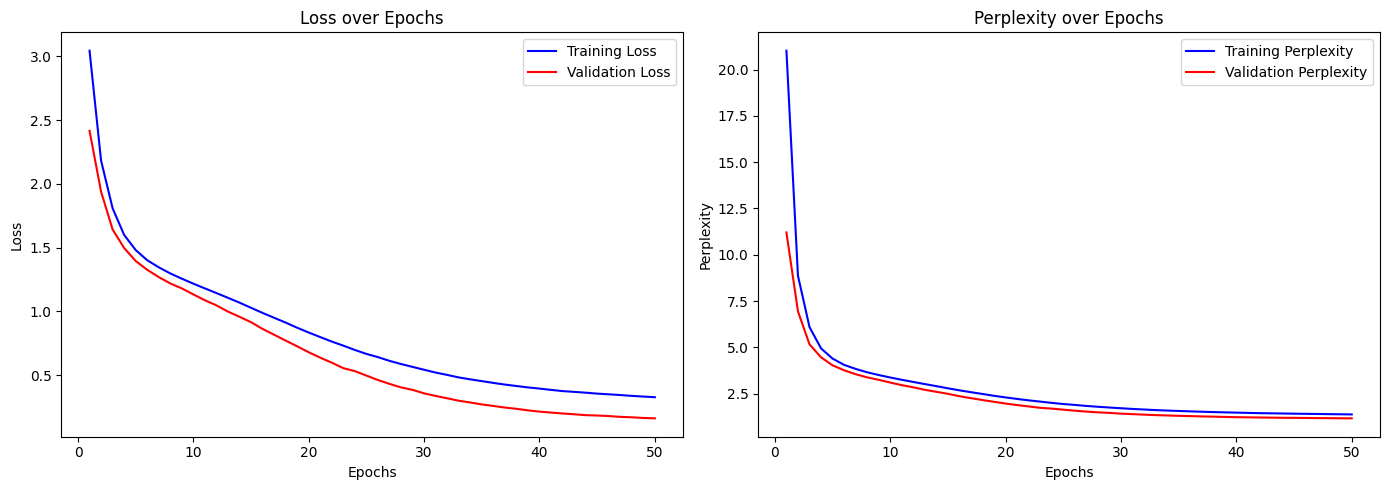

In [9]:
char_generator.plot_loss_and_perplexity()

Podemos observar que ambos indicadores disminuyen consistentemente tanto en el conjunto de entrenamiento como en el de validación, lo que sugiere que el modelo está aprendiendo correctamente y generalizando bien.

En el caso de la pérdida, se observa una tendencia convergente entre las curvas de entrenamiento y validación, con valores más bajos hacia el final del entrenamiento. Esto indica que no hay un sobreajuste significativo y que el modelo se comporta de manera similar en los datos de validación.

La perplexidad también disminuye de manera constante, lo que es positivo, ya que implica que el modelo está mejorando su capacidad para predecir el siguiente carácter en la secuencia. Hacia el final del entrenamiento, los valores de perplexidad son bajos tanto en entrenamiento como en validación, lo que refleja un buen desempeño general.

Esto sugiere que el modelo tiene un entrenamiento estable y logra un buen balance entre la pérdida y la perplexidad.

# Ejemplo
## Generamos texto a nivel de caracteres utilizando diferentes valores de temperatura (0.2, 0.5, 1.0, 1.5) para explorar el impacto de la aleatoriedad en las predicciones del modelo.


In [10]:
temperatures = [0.2, 0.5, 1.0, 1.5]
for temp in temperatures:
    generated_text = char_generator.generate_text(
        start_string="To be, or not to be",
        num_generate=500,
        temperature=temp
    )
    print(f"\nCharacter-level Generation with temperature={temp}:\n")
    print(generated_text)
    print("\n" + "="*80 + "\n")


Character-level Generation with temperature=0.2:

To be, or not to be throw down their abuses?

ESCALUS:
How dost thou know me?

MENENIUS:
You have often drown'd by me,
Displaced my personate by the violent
bore. But here looks so much.

Second Citizen:
You shall have no tender, good my lord.

ANGELO:
Then I will bring you up, that when you say
My father reverend and unfashionable.
O God, which this blood madest me, that he hath something service
His death's blood to be choose with that good day
But the resolve such heavy officers
After a story ready at the sea,




Character-level Generation with temperature=0.5:

To be, or not to be throw down the heir
Of the Lord Hungerford.

BIANCA:
Fie, fie, the tent more benefit that yet.
O execute, Clarence, now to the purpose! What
was done to Elbow's wife, that he hath cause to
complain of? Come, sirs: come on, bring me
To the deadly consul.

CORIOLANUS:
You must retire them for the profited
you have often heard him say so; sir: well, was
the

Con una temperatura de 0.2, el texto generado es muy predecible y sigue patrones consistentes, pero tiende a ser repetitivo y carece de creatividad. Esto se debe a que el modelo prioriza las opciones más probables, resultando en frases altamente coherentes pero con poca variación.

A medida que aumentamos la temperatura a 0.5, se logra un equilibrio entre coherencia y diversidad. El texto es menos repetitivo y presenta variaciones interesantes, lo que lo hace más dinámico y atractivo sin perder sentido.

Cuando la temperatura alcanza 1.0, el modelo genera texto con mayor diversidad y creatividad, aunque empieza a perder coherencia en algunos fragmentos. Esto sucede porque el modelo explora opciones menos probables, lo que introduce elementos novedosos, pero con el riesgo de reducir la fluidez del contenido.

Con una temperatura de 1.5, el texto se vuelve extremadamente creativo, pero pierde la estructura lógica y coherencia. La generación incluye opciones poco probables que hacen que las frases parezcan desconectadas o caóticas, siendo más útiles en contextos donde la creatividad extrema es valorada.

Se puede observar cómo la temperatura controla el balance entre creatividad y coherencia en el texto generado, permitiendo ajustar la generación según las necesidades.

## Creamos una instancia de 'WordLevelTextGenerator', cargamos y preparamos los datos a nivel de palabras, construimos el modelo y lo compilamos para su entrenamiento.


In [11]:
word_generator = WordLevelTextGenerator()
word_generator.load_data()
word_generator.prepare_dataset()
word_generator.build_model()
word_generator.compile_model()

## Entrenamos el modelo de 'WordLevelTextGenerator' durante 300 épocas utilizando los datos preparados.


In [12]:
word_generator.train_model(epochs=300)

Epoch 1/300
25/25 [==============================] - 14s 387ms/step - loss: 8.7145 - accuracy: 0.0231 - val_loss: 7.9278 - val_accuracy: 0.0269
Epoch 2/300
25/25 [==============================] - 15s 607ms/step - loss: 7.9114 - accuracy: 0.0258 - val_loss: 7.7652 - val_accuracy: 0.0265
Epoch 3/300
25/25 [==============================] - 10s 389ms/step - loss: 7.8092 - accuracy: 0.0265 - val_loss: 7.6927 - val_accuracy: 0.0264
Epoch 4/300
25/25 [==============================] - 9s 348ms/step - loss: 7.7853 - accuracy: 0.0272 - val_loss: 7.7098 - val_accuracy: 0.0281
Epoch 5/300
25/25 [==============================] - 16s 611ms/step - loss: 7.7826 - accuracy: 0.0265 - val_loss: 7.7133 - val_accuracy: 0.0274
Epoch 6/300
25/25 [==============================] - 14s 540ms/step - loss: 7.7681 - accuracy: 0.0263 - val_loss: 7.6952 - val_accuracy: 0.0265
Epoch 7/300
25/25 [==============================] - 13s 533ms/step - loss: 7.7552 - accuracy: 0.0262 - val_loss: 7.6556 - val_accuracy: 

## Visualizamos las curvas de pérdida y perplexidad.


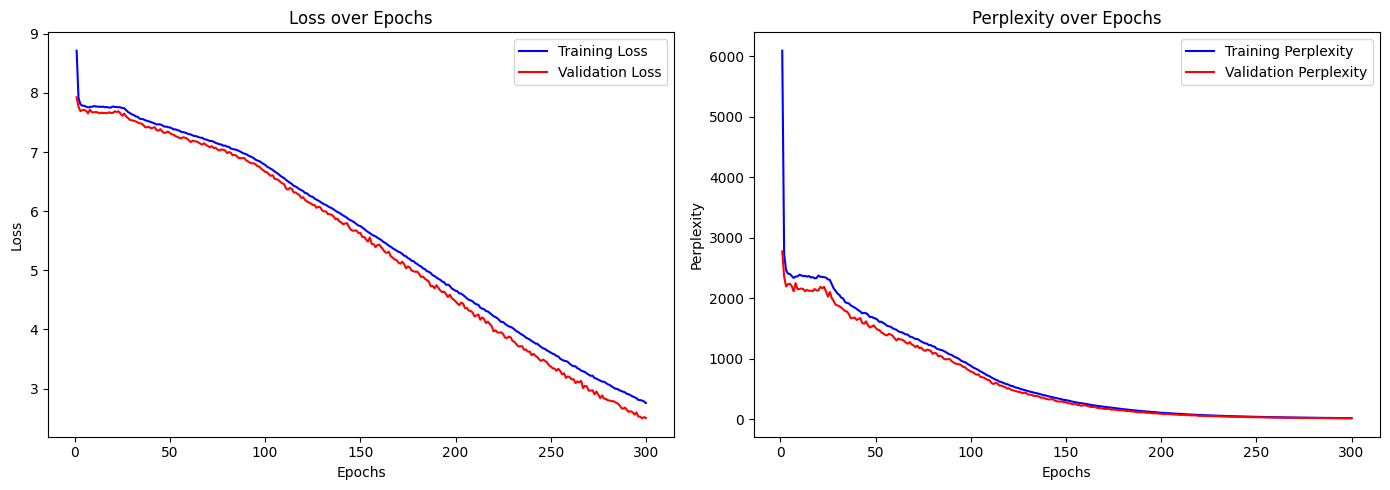

In [13]:
word_generator.plot_loss_and_perplexity()


El gráfico muestra cómo evolucionan las métricas de pérdida y perplejidad durante el entrenamiento del modelo. Se observa una disminución constante tanto en el conjunto de entrenamiento como en el de validación, lo que indica que el modelo está aprendiendo de manera efectiva y no presenta señales significativas de sobreajuste. La convergencia hacia valores bajos en ambas métricas sugiere un entrenamiento estable y una mejora en la capacidad predictiva del modelo.

## Generamos texto a nivel de palabras utilizando el modelo 'WordLevelTextGenerator' con diferentes valores de temperatura (0.2, 0.5, 1.0, 1.5) para observar cómo varía la coherencia y creatividad.


In [14]:
temperatures = [0.2, 0.5, 1.0, 1.5]
for temp in temperatures:
    generated_text = word_generator.generate_text(
        start_string="To be, or not to be",
        num_generate=50,
        temperature=temp
    )
    print(f"\nWord-level Generation with temperature={temp}:\n")
    print(generated_text)
    print("\n" + "="*80 + "\n")


Word-level Generation with temperature=0.2:

To be, or not to be in favour. FRIAR LAURENCE: Talk not to me, but we shall be doubted I shall have a woman's daughter. KING RICHARD II: What would I see the king of magistrate; Letters should Romeo have been mercenary. First Gentleman: Hold; get you walk? KING HENRY VI: Ah, how it is a



Word-level Generation with temperature=0.5:

To be, or not to be as they had spoke: but farewell compliment! Dost thou hast set thee in the earth of the queen of Mercutio's earth And in the night in our quailing breasts; But I may make you pluck upon my mind--to make thee and if he had bought so evident Upon the bell:



Word-level Generation with temperature=1.0:

To be, or not to be how had not lose this fair. QUEEN MARGARET: There is my fault, why come not hence; with loathsome Dorset, but so short as ever think there Weigh'd you well at this. CLIFFORD: Now, madam, I will speak to-night? BUCKINGHAM: The father true? loves: But I have still mercenary. J

Podemos observar que el modelo genera texto a nivel de palabras, lo que significa que construye frases seleccionando palabras completas en lugar de caracteres individuales. Este enfoque permite al modelo trabajar directamente con la estructura semántica y sintáctica del lenguaje, utilizando las probabilidades aprendidas del vocabulario.

Con temperaturas bajas como 0.2, el texto generado es altamente predecible y coherente, ya que el modelo prioriza las palabras más probables. Sin embargo, esta predictibilidad resulta en frases repetitivas y con poca creatividad. A medida que se incrementa la temperatura, como en 0.5, el texto logra un equilibrio entre coherencia y diversidad, introduciendo variaciones más interesantes sin perder la estructura lógica.

En temperaturas más altas, como 1.0, el modelo genera texto con mayor diversidad y creatividad, pero comienza a perder cohesión en las frases, lo que lleva a combinaciones menos naturales. Finalmente, con una temperatura de 1.5, la selección de palabras se torna casi aleatoria, resultando en frases que son extremadamente creativas pero carecen de lógica y estructura.

Este comportamiento refleja cómo la temperatura controla el balance entre coherencia y creatividad en la generación de texto. A nivel de palabras, se pueden observar transiciones claras desde un texto estructurado y monótono hacia combinaciones más arriesgadas y caóticas, dependiendo del valor de temperatura seleccionado.

# Conclusión

En este ejercicio, trabajamos con modelos basados en redes neuronales recurrentes (RNN), específicamente LSTM y GRU, para generar texto tanto a nivel de caracteres como de palabras. A través de la experimentación, analizamos cómo los parámetros del modelo, el entrenamiento y la temperatura afectan el balance entre coherencia y creatividad en el texto generado.

A nivel de caracteres, el modelo demostró ser efectivo en la captura de patrones del texto fuente. Con temperaturas bajas, generó secuencias coherentes pero con cierta repetitividad, mientras que con temperaturas más altas, introdujo diversidad y creatividad a costa de una menor cohesión en las frases.

En el caso de la generación a nivel de palabras, el modelo mostró su capacidad para trabajar con unidades más complejas del lenguaje. Las temperaturas bajas favorecieron textos estructurados y predecibles, mientras que las altas promovieron mayor diversidad en las combinaciones, aunque algunas veces resultaron en frases desconectadas.

Las curvas de pérdida y perplexidad evidenciaron un entrenamiento estable y una adecuada generalización. Los resultados también destacaron cómo la selección de parámetros, como el número de épocas y la arquitectura del modelo, es clave para lograr un desempeño óptimo.

Este ejercicio permitió comprender las diferencias entre la generación de texto a nivel de caracteres y palabras, y cómo ajustar variables como la temperatura para influir directamente en el resultado. La capacidad de balancear coherencia y creatividad es esencial para adaptar los modelos a diferentes contextos y aplicaciones.